In [1]:
suppressPackageStartupMessages(suppressWarnings({
    library(tidyr)
    library(ggplot2)
    library(dplyr)
    library(igraph)
    library(gtools)
    library(gridExtra)
    library(network)
    library(sna)
    library(ggnetwork)
    library(dagitty)
    #library(MRPC)
    library(glasso)
    library(corpcor)
    library(pROC)
    library(ggpubr)
}))

In [2]:
#data initialisation functions
options(warn=-1)

# empty matrix dims p x p
# set to ident matrix
# rbinom <- number of observations, size of trials, probability of success
# scale() forces column centering by subtracting mean of each column from their data points
# d <- split each column into the list and add randomly distributed numbers to each element
# do.call(cbind, d) concatenates the list elements to reform the previous matrix representation

init_data <- function(n, p){
    r <- matrix(0, p, p)
    diag(r) <- 1
    g <- matrix(rbinom(n*p, 2, 0.5), n)
    g <- scale(g)
    d <- list()
    for(i in 1:p){
        d[[i]] <- g[,i] + rnorm(n)
    }
    d <- do.call(cbind, d)
    return(list(r=r, d=d, g=g, p=p))
}

# r is a p x p ident matrix, this sets location j, i to the effect
# d is the scaled data representation, this adds the value of d[,i] * the effect to d[,j]
# conf effect is applied to the node level weightings, not the true graph edges
make_edge <- function(i, j, effect, data, conf_effect=0)
{
    data$r[j, i] <- effect
    u <- rnorm(nrow(data$d))
    data$d[,i] <- data$d[,i]+ u*conf_effect
    data$d[,j] <- data$d[,j] + data$d[,i] * effect + u*conf_effect
    return(data)
}

#Work on generating good data variants, cycles etc.
generate_cycle_set <- function(nodes, ncycles=-1, scycle=3){
    if (ncycles == -1) {
        ncycles <- sample(0:nodes$l, 1)
    }
    cycle_lst <- NULL 
    x <- 0
    while (x != ncycles){
        cycle_size <- scycle#sample(3:nodes$l, 1)
        samp <- c(1:cycle_size)#sample(nodes$n, cycle_size)
        cycle_lst <- cbind(cycle_lst, samp)
        x <- x + 1
    }
    return(unique(cycle_lst))
}

generate_edge_set <- function(nodes, nedges=-1){
    if (nedges == -1) {
        nedges <- sample(0:choose(nodes$l,2), 1)
    }
    edge_lst <- NULL
    x <- 0
    while (x != nedges){
        samp <- sample(nodes$n, 2)
        edge_lst <- cbind(edge_lst, c(samp))
        x <- x + 1
    }
    return(unique(edge_lst))
}


#Takes a n x 2 edgeset and augments the data to represent it
set_to_edges <- function(set, data, edge=FALSE){
    if (is.null(set) | length(set) < 1){
        return(data)
    }
    l <- ncol(set)
    for (i in 1:l){
        cycle <- set[,i]
        if (edge){
            effect <- runif(1,min=-4,max=4)
            if(effect == 0){
                effect <- 1
            }
            conf_ef <- runif(1,min=-2,max=2)
            data <- make_edge(cycle[[1]],cycle[[2]], effect, data, conf_effect = conf_ef)
        }else{
            for (j in 1:k){
                effect <- runif(1,min=-4,max=4)
                if(effect == 0){
                    effect <- 1
                }
                nxt <- (j+1)%%(k+1)
                if (nxt == 0){
                    nxt <- 1
                }
                conf_ef <- runif(1,min=-2,max=2)
                data <- make_edge(cycle[j],cycle[nxt], effect, data, conf_effect = conf_ef)
                
            }
        }
    }
    return(data)
}


# Either generates edge set and makes edges, or makes edges for a given edge set
graph_gen <- function(ncycles, scycle, nedges, data, edgeset = 0){
    nodes <- list(n=c(1:data$p),l=data$p)
    if(length(edgeset)>0){
        if (edgeset != 0){
            data <- set_to_edges(edgeset, data, TRUE)
        }else{
            # recommended to keep relatively sparse, as edges can accidentally create cycles
            cycles <- generate_cycle_set(nodes, ncycles, scycle=scycle)
            edges <- generate_edge_set(nodes, nedges)
            if (length(cycles) != 0){data <- set_to_edges(cycles, data)}
            if (length(edges) != 0){data <- set_to_edges(edges, data, TRUE)}
        }
    }
    
    
    return(data)
}

[1] "double"


2,4
4,1


In [3]:
# MSE

meanSquareError <- function(gr, tGr){
    MSE <- sum((tGr - gr)^2)/length(tGr)
}

In [4]:
# is.finite() & is.finite() pairwise AND comparison of integer finiteness, Inf, Inf, NaN, Na all result in False
# sum tallies the number of True occurences
# y[index] strips y to only finite values
# rsq = correlation^2
# this is the square of the correlation coefficient
# tval = pearson product-moment correlation coefficient fval is the square of tval
# this is identical to the built-in R cor() pearson method
# pf is a cumulative distribution function(values, numerator dgf, denom dgf, tail or not)

fastAssoc <- function(y, x){
    index <- is.finite(y) & is.finite(x)
    n <- sum(index)
    y <- y[index]
    x <- x[index]
    
    vx <- var(x)
    bhat <- cov(y, x) / vx
    ahat <- mean(y) - bhat * mean(x)
    

    rsq <- (cov(y, x))^2 / (vx * var(y))
    fval <- rsq * (n-2) / (1-rsq)
    tval <- sqrt(fval)
    se <- abs(bhat / tval)
    
    p <- pf(fval, 1, n-2, lowe=F)
    return(
        list(ahat=ahat, bhat=bhat, se=se, fval=fval, pval=p)
    )
}

# Simple linear regression applied to data based on least square estimates bhat and ahat
# bhat = conv(y, x)/var(x)
# ahat = Ex(y) - bhat * Ex(x)
# fitted values Y : Yi = ahat + bhat * xi

getFittedVals <- function(y, x){
    n <- length(x)
    bhat <- cov(y, x) / var(x)
    ahat <- mean(y) - bhat * mean(x)
    fitted <- ahat + x * bhat
    return(fitted)
}

#tsls gets the fitted values for some data, and then applies fastAssoc to the resulting data with the original data

tsls <- function(y, x, g){
    xhat <- getFittedVals(x, g)
    res <- fastAssoc(y, xhat)
    return(res)
}

# ncol(data) number of columns in data
# make matrix of size p x p, all ones
# same but all zeroes
# for all none diagonal matrices{
# b non-diagonals set to bhat value, cov(y, x)/var(x), diags = cov(x, x)/var(x) = 1
# se non-diagonals set to se value, abs(bhat/tval)
# }

graph_mr <- function(data){
    p <- ncol(data$d)
    b <- matrix(1, p, p)
    se <- matrix(0, p, p)
    for(i in 1:p){
        for(j in 1:p){
            if(i != j){
                a <- tsls(data$d[, i], data$d[, j], data$g[, j])
                b[i, j] <- a$bhat
                se[i, j] <- a$se
            }
        }
    }
    return(list(b=b, se=se))
}

# stopifnot used to prevent indexing outside the matrix, or performing checks on a single node matrix
# a is a vector of form (first, list of nodes w/out first and last, last)
# permutations is of the form (size of input, size of target, data)
# first permutations for single step paths x -> y -> z are calced, then for increasing path size up to graph size
# find only perms with start = index 1 and last = final index
# only accept unique paths 2 1 4 3 is considered the same as 2 4 1 3
# Returned list are all paths from first to last ordered by increasing size

get_paths <- function(first, last, size)
{
    stopifnot(first <= size)
    stopifnot(last <= size)
    stopifnot(size > 2)
    a <- c(first, c(1:size)[-c(first, last)], last)
    combs <- 3:size
    l <- list()
    for(i in combs)
    {
        b <- permutations(size, i, a)
        b <- b[b[,1] == first & b[,i] == last, , drop=FALSE]
        b1 <- b[,-c(1, ncol(b)), drop=FALSE]
        index <- apply(b1, 1, function(x) all(diff(x) >= 1))
        l[[i-2]] <- b[index, , drop=FALSE]
    }
    return(l)
}

# for each path size, for each path, get the length of the path minus 1, create a zero vector of that length
# set each element of that vector to the mat weight of that edge on the current path
# get the effect product for the path and add to the total product

get_prods <- function(paths, mat)
{
    s <- 0
    for(i in 1:length(paths))
    {
        p <- paths[[i]]
        for(j in 1:nrow(p))
        {
            r <- p[j, ]
            l <- length(r) - 1
            out <- rep(0, l)
            for(k in 1:l)
            {
                out[k] <- mat[r[k], r[k+1]]
            }
            s <- s + prod(out)
        }
    }
    return(s)
}

1.0,0,0,0,0
2.0,1,0,0,0
8.0,4,1,0,0
-24.0,-12,-3,1,0
-95.8,-48,-12,4,1


In [5]:
# Methods:

# a = negative of the inversion of res$b, with diag set to 1, as trait self-relations are trivially related
inversion_method <- function(res){
    a <- -solve(res$b)
    diag(a) <- 1
    return(a)
}

# n = number of rows
# mmat is a zero matrix the same size as res$b
# diag of mmat set to 1 as discussed above
# for none diags, minus the prods of possible i, j paths from the current effect i, j
mediation_method <- function(res){
    mat <- res$b
    n <- nrow(mat)
    mmat <- matrix(0, nrow(mat), ncol(mat))
    for(i in 1:n){
        for(j in 1:n){
            if(i == j){
                mmat[i,j] <- 1
            } else {
                p <- get_paths(i, j, n)
                mmat[i,j] <- mat[i,j] - get_prods(p, mat)
            }
        }
    }
    return(mmat)
}

# set the diag of mat to zero, then get the inverse of (ident matrix (size nrow(mat)) + original matrix)
# then matrix multiply with mat
deconvolution_method <- function(res){
    mat <- res$b
    diag(mat) <- 0
    out <- mat %*% solve(diag(nrow(mat)) + mat)
    diag(out) <- 1
    return(out)
}

# function that matrix multiplies x by the inverse of itself plus a same size ident matrix 
dir <- function(x)
    return(x %*% solve(x + diag(nrow(x))))

# normalizes values by a value alpha, dependent on the relative scales of max_e and min_e, being the largest and smallest eigenvalues
normalize_beta <- function(x, beta=0.95){
    xe <- eigen(x)
    max_e <- max(xe$values)
    min_e <- min(xe$values)
    alpha <- min(beta / ((1-beta) * max_e), -beta / ((1+beta) * min_e))
    return(alpha)
}

# make correlation matrix
# obfuscating function call for my own readability
make_cor_mat <- function(d){
    correl <- list(b=cor(d))
    return(correl)
}

#deconv correlation matrix, normalize determines whether to normalize, alpha act as an adjustment, the diagonal 1s are stripped out for dir()
deconv_corr <- function(corr, normalize=TRUE, alpha=1){
    inp <- corr
    if(normalize && alpha == 1){
        alpha <- normalize_beta(inp)
        deconv_matrix <- dir(inp*alpha)   
    }else if (alpha == 1)
        deconv_matrix <- dir(inp)
    else
        deconv_matrix <- dir(alpha * (inp))
    return(deconv_matrix)
}



In [6]:
# visualisation functions

plot_from_matrix <- function(mat, title="", MSE)
{
    diag(mat) <- 0
    net <- graph.adjacency(round(t(mat), 1), weighted=TRUE, mode="directed")
    layout=layout.circle(net)
    plot(net, edge.label = E(net)$weight, main=title, sub=MSE, layout=layout)
}

plot_from_matrix_clean <- function(mat, title="")
{
    diag(mat) <- 0
    n <- network(round(t(mat), 1))
    p <- ggplot(n, aes(x = x, y = y, xend = xend, yend = yend)) +
    geom_edges(arrow = arrow(length = unit(6, "pt"), type = "closed")) +
    geom_nodes() +
    theme_blank() +
    labs(title=title)
    return(p)
}

In [7]:
# # dagitty facilitator


# Gets a random dag of given nodes and sparsity
getRandomDag <- function(nodes, sparsity){
    dag <- NULL
    dag <- randomDAG(nodes, sparsity)
    edg <- makeEdgeList(edges(dag))
    
    return(edg)
}

# takes a DAGitty edge list and reformats it for use
makeEdgeList <- function(edges){
    lst <- apply(edges,1, function(x)(return(c(strtoi(sub('.', '', x['v'])), strtoi(sub('.', '', x['w']))))))
    return(lst)
}

In [8]:
# Data checks

# Calculates the ROC for given matrices
roc.for.matrix <-
function(networkweights ,adjacencymatrix ,filtermatrix = NULL) {
    require(pROC)
    x <- abs(networkweights)
    y <- adjacencymatrix
    suppressWarnings(roc(y, x))
}

# Classifies non-binary result matrix
success_thresholder <- function(matr, truth,thresh = 0.15, adj=FALSE){
    matr <- abs(matr)
    truth <- abs(truth)
    if (adj == TRUE){
        out <- ifelse(matr > 0.5, 1, 0)
    }else{
        out <- ifelse(abs(matr-truth) < thresh*matr, 1, 0)
    }
    return(out)
}


single_test <- function(gsize, datsize, nedges, ncycles, scycles, prRes=FALSE, edgeset = 0, data = 0, broken=FALSE){
    dat <- data
    dat <- graph_gen(ncycles, scycles, nedges, dat, edgeset = edgeset)
    # For missing node tests, strips a data column
    if (broken == TRUE && length(edgeset) > 0){
        rm <- sample(edgeset, 1)[[1]][1]
        
        dat$d <- dat$d[,-rm]
        dat$g <- dat$g[,-rm]
        dat$r <- dat$r[,-rm]
        dat$r <- dat$r[-rm,]
    }
    res <- graph_mr(dat) 
    corr <- make_cor_mat(dat$d)
    res1 <- mediation_method(res)
    res2 <- inversion_method(res)
    res3 <- deconvolution_method(res)
    res4 <- deconv_corr(corr$b)
    MSE1=meanSquareError(res1, dat$r)
    MSE2=meanSquareError(res2, dat$r)
    MSE3=meanSquareError(res3, dat$r)
    MSE4=meanSquareError(res4, dat$r)
    MSEB=meanSquareError(res$b, dat$r)
    
    adj_mat <- ifelse(dat$r != 0, 1, 0)
    diag(res4) <- 1
    resall <- rbind(
        data.frame(estimate=c(res1), truth=c(dat$r), method="Mediation", mse=MSE1, auc=c(auc(roc.for.matrix(success_thresholder(res1,dat$r,adj=FALSE),adj_mat)))),
        data.frame(estimate=c(res2), truth=c(dat$r), method="Inversion", mse=MSE2, auc=c(auc(roc.for.matrix(success_thresholder(res2,dat$r,adj=FALSE),adj_mat)))),
        data.frame(estimate=c(res3), truth=c(dat$r), method="Feizi", mse=MSE3, auc=c(auc(roc.for.matrix(success_thresholder(res3,dat$r,adj=FALSE),adj_mat)))),
        data.frame(estimate=c(res4), truth=c(dat$r), method="ND Correlation mat", mse=MSE4, auc=c(auc(roc.for.matrix(success_thresholder(res4,dat$r,adj=TRUE),adj_mat)))),
        data.frame(estimate=c(res$b), truth=c(dat$r), method="Total effects", mse=MSEB, auc=c(auc(success_thresholder(res$b,dat$r,adj=TRUE),adj_mat)))
    )

    if(prRes){
        par(mfrow=c(2,3))
        plot_from_matrix(dat$r, "True graph", 0)
        plot_from_matrix(res$b, "Total effects" ,MSEB)
        plot(1, type="n", axes=F, xlab="", ylab="")
        plot_from_matrix(res1, "Mediation Method" , MSE1)
        plot_from_matrix(res2, "Inversion Method" , MSE2)
        plot_from_matrix(res3, "Feizi Method" , MSE3)
        plot_from_matrix(res4, "ND Correlation Mat" , MSE4)
    }
    return(resall)
}


do_test <- function(iter, nodes, observations, edges, cycles, cycle_size, edgeset = 0, broken = FALSE, sparsity = 0){
    #print(sparsity)
    avgRes <- rbind(
        data.frame(mseTot=0,mseAvg=0,method="Mediation",aucTot=0,aucAvg=0,aucSd=0),
        data.frame(mseTot=0,mseAvg=0,method="Inversion Method",aucTot=0,aucAvg=0,aucSd=0),
        data.frame(mseTot=0,mseAvg=0,method="Feizi Method",aucTot=0,aucAvg=0,aucSd=0),
        data.frame(mseTot=0,mseAvg=0,method="ND Correlation Mat",aucTot=0,aucAvg=0,aucSd=0)
    )
    MedSd <- list()
    InvSd <- list()
    FeiSd <- list()
    NDSd <- list()
    avgCompRes <- list()
    for (x in 1:(edgeset+1)){
        avgCompRes <- c(avgCompRes,list(avgRes))
    }
    for(it in 1:iter){
        MedSdTmp <- list()
        InvSdTmp <- list()
        FeiSdTmp <- list()
        NDSdTmp <- list()
        pr = FALSE
        if (iter == 1){
            pr = FALSE
        }
        dat <- init_data(observations, nodes)
        totalres <- list()
        if(sparsity == -1){
            for(i in seq(0.01,1,length.out=100)){
                sp <- i
                edgeset2 <- getRandomDag(nodes, sp)
                edgeRes <- single_test(nodes, observations, edges, cycles, cycle_size, prRes = pr, edgeset = edgeset2, data=dat, broken=broken)
                totalres <- c(totalres, list(edgeRes))
            }
            
        }else{

            for(edge_lim in 0:edgeset){
                if (edge_lim == 0) {
                    edgeset2 = NULL
                }else if (sparsity > 0){
                    edgeset2 <- getRandomDag(edge_lim, sparsity)
                }else{
                    edgeset2 = list()
                    for(ed in 1 : edge_lim){
                        edgeset2 <- cbind(edgeset2, c(ed, ifelse(((ed+1)%%(edgeset+1) == 0), 1, (ed+1))))
                    }
                }

                if(edge_lim < 3){
                    broken=FALSE
                }
                edgeRes <- single_test(nodes, observations, edges, cycles, cycle_size, prRes = pr, edgeset = edgeset2, data=dat, broken=broken)
                totalres <- c(totalres, list(edgeRes))
            }
        }
        for(x in 1:(edgeset+1)){
            tempMse <- totalres[[x]]
            avgCompRes[[x]][1, 'mseTot'] <- avgCompRes[[x]][1, 'mseTot'] + tempMse[1, 'mse']
            avgCompRes[[x]][1, 'aucTot'] <- avgCompRes[[x]][1, 'aucTot'] + tempMse[1, 'auc']
            MedSdTmp <- c(MedSdTmp,tempMse[1, 'auc'])
            avgCompRes[[x]][2, 'mseTot'] <- avgCompRes[[x]][2, 'mseTot'] + tempMse[1 + (nodes^2), 'mse']
            avgCompRes[[x]][2, 'aucTot'] <- avgCompRes[[x]][2, 'aucTot'] + tempMse[1 + (nodes^2), 'auc']
            InvSdTmp <- c(InvSdTmp,tempMse[1 + (nodes^2), 'auc'])
            avgCompRes[[x]][3, 'mseTot'] <- avgCompRes[[x]][3, 'mseTot'] + tempMse[1 + (nodes^2)*2, 'mse']
            avgCompRes[[x]][3, 'aucTot'] <- avgCompRes[[x]][3, 'aucTot'] + tempMse[1 + (nodes^2)*2, 'auc']
            FeiSdTmp <- c(FeiSdTmp,tempMse[1+ (nodes^2)*2, 'auc'])
            avgCompRes[[x]][4, 'mseTot'] <- avgCompRes[[x]][4, 'mseTot'] + tempMse[1 + (nodes^2)*3, 'mse']
            avgCompRes[[x]][4, 'aucTot'] <- avgCompRes[[x]][4, 'aucTot'] + tempMse[1 + (nodes^2)*3, 'auc']
            NDSdTmp <- c(NDSdTmp,tempMse[1 + (nodes^2)*3, 'auc'])
        }
        MedSd <- cbind(MedSd,MedSdTmp)
        InvSd <- cbind(InvSd,InvSdTmp)
        FeiSd <- cbind(FeiSd,FeiSdTmp)
        NDSd <- cbind(NDSd,NDSdTmp)        
    }
    displayDat <- list()
    for(x in 1:(edgeset+1)){
        avgCompRes[[x]][1, 'mseAvg'] <- avgCompRes[[x]][1, 'mseTot'] / iter
        avgCompRes[[x]][2, 'mseAvg'] <- avgCompRes[[x]][2, 'mseTot'] / iter
        avgCompRes[[x]][3, 'mseAvg'] <- avgCompRes[[x]][3, 'mseTot'] / iter
        avgCompRes[[x]][4, 'mseAvg'] <- avgCompRes[[x]][4, 'mseTot'] / iter
        avgCompRes[[x]][1, 'aucAvg'] <- avgCompRes[[x]][1, 'aucTot'] / iter
        avgCompRes[[x]][2, 'aucAvg'] <- avgCompRes[[x]][2, 'aucTot'] / iter
        avgCompRes[[x]][3, 'aucAvg'] <- avgCompRes[[x]][3, 'aucTot'] / iter
        avgCompRes[[x]][4, 'aucAvg'] <- avgCompRes[[x]][4, 'aucTot'] / iter
        avgCompRes[[x]][1, 'aucSd'] <- sd(as.numeric(as.vector(MedSd[x,])))
        avgCompRes[[x]][2, 'aucSd'] <- sd(as.numeric(as.vector(InvSd[x,])))
        avgCompRes[[x]][3, 'aucSd'] <- sd(as.numeric(as.vector(FeiSd[x,])))
        avgCompRes[[x]][4, 'aucSd'] <- sd(as.numeric(as.vector(NDSd[x,])))

        displayDat <- rbind(displayDat, cbind(cbind(avgCompRes[[x]][1,'aucAvg'],avgCompRes[[x]][1,'aucSd']),cbind(avgCompRes[[x]][2,'aucAvg'],avgCompRes[[x]][2,'aucSd']),cbind(avgCompRes[[x]][3,'aucAvg'],avgCompRes[[x]][3,'aucSd']),cbind(avgCompRes[[x]][4,'aucAvg'],avgCompRes[[x]][4,'aucSd'])))
    }
    return(displayDat)

In [9]:
#Test Framework and plotting function

plot_Data <- function(average_auc, n_size, sparse){
    p_values = seq(0 , 100, length.out = n_size+1)
    medsd=as.numeric(rbind(as.numeric(average_auc[,1])-as.numeric(average_auc[,2]),as.numeric(average_auc[,1])+as.numeric(average_auc[,2])))
    invsd=as.numeric(rbind(as.numeric(average_auc[,3])-as.numeric(average_auc[,4]),as.numeric(average_auc[,3])+as.numeric(average_auc[,4])))
    feisd=as.numeric(rbind(as.numeric(average_auc[,5])-as.numeric(average_auc[,6]),as.numeric(average_auc[,5])+as.numeric(average_auc[,6])))
    NDsd=as.numeric(rbind(as.numeric(average_auc[,7])-as.numeric(average_auc[,8]),as.numeric(average_auc[,7])+as.numeric(average_auc[,8])))

    df <- data.frame(
        sp=as.numeric(rbind(p_values,p_values,p_values,p_values)),
        sdsp=as.numeric(rbind(p_values,p_values,p_values,p_values,p_values,p_values,p_values,p_values)),
        avgAuc = as.numeric(rbind(as.numeric(average_auc[,1])),as.numeric(average_auc[,3]),as.numeric(average_auc[,5]),as.numeric(average_auc[,7])),
        Aucsd=as.numeric(rbind(medsd,invsd,feisd,NDsd)),
        Col = as.character(rbind(rep('A',n_size+1),rep('B',n_size+1),rep('C',n_size+1),rep('D',n_size+1))),
        ColSd = as.character(rbind(rep('A',2*(n_size+1)),rep('B',2*(n_size+1)),rep('C',2*(n_size+1)),rep('D',2*(n_size+1)))))
    par(
        mfrow = c(1, 1),
        mar = c(4.1 , 4.1, 1.2, 0.1) ,
        xpd = TRUE ,
        mgp = c(2, .5, 0),
        family = 'serif'
    )
    if(sparse == TRUE){
        plot(
        p_values,
        average_auc[, 1],
        xlab = "% Network Sparsity",
        ylab = "Average AUC",
        xlim = c(0, 100),
        ylim = c(0.5, 1),
        pch = 19,
        col = 5,
        lty = 1,
        main = "Network sparsity against AUC",
    )
    }else{
        plot(
        p_values,
        average_auc[, 1],
        xlab = "% Available subgraph size",
        ylab = "Average AUC",
        xlim = c(0, 100),
        ylim = c(0.5 , 1),
        pch=19,
        col = 5,
        lty = 1,
        main = "Graph Density against AUC",
        sub = paste(c(n_size, "node network"), collapse = " ")
    )
    }
    lines(lowess(p_values, average_auc[, 1]), col = 5)
    lines(lowess(p_values, average_auc[, 3]), col = 2)
    lines(lowess(p_values, average_auc[, 5]), col = 3)
    lines(lowess(p_values, average_auc[, 7]), col = 4)
    points(p_values , average_auc[, 3], pch=19,col = 2)
    points(p_values , average_auc[, 5], pch=19,col = 3)
    points(p_values , average_auc[, 7], pch=19,col = 4)

    legend(
        "bottomright",
        inset = c(0.3 , 0),
        c("Mediation method", "Inversion method","Feizi method","ND Correlation Method"),
        col = c(5,2,3,4),
        lty = 1,
        bty = "n",
        y.intersp = 1.5
    )
    
    #sd plots
    
    Aplt <- ggplot(subset(df,Col %in% c('A')), aes(x=head(sp,n_size + 1),y=head(avgAuc,n_size+1), colour='cyan')) +
        stat_summary(geom="ribbon", fun.ymin="min", fun.ymax="max",fill='cyan', aes(x=sdsp,y=Aucsd), alpha=0.1) +
        theme_bw() + 
        coord_cartesian(xlim =p_values, ylim = c(0.5, 1)) +
        labs(x = "% Available Subgraph", y='AUC') +
        theme(legend.position = "none")
    Bplt <- ggplot(subset(df,Col %in% c('B')), aes(x=head(sp,n_size + 1),y=head(avgAuc,n_size+1), colour='red')) +
        stat_summary(geom="ribbon", fun.ymin="min", fun.ymax="max",fill='red', aes(x=sdsp,y=Aucsd), alpha=0.1) +
        theme_bw() + 
        coord_cartesian(xlim =p_values, ylim = c(0.5, 1)) +
        labs(x = "% Available Subgraph", y='AUC') +
        theme(legend.position = "none")
    Cplt <- ggplot(subset(df,Col %in% c('C')), aes(x=head(sp,n_size + 1),y=head(avgAuc,n_size+1), colour='green')) +
        stat_summary(geom="ribbon", fun.ymin="min", fun.ymax="max",fill='green', aes(x=sdsp,y=Aucsd), alpha=0.1) +
        theme_bw() + 
        coord_cartesian(xlim =p_values, ylim = c(0.5, 1)) +
        labs(x = "% Available Subgraph", y='AUC') +
        theme(legend.position = "none")
    Dplt <- ggplot(subset(df,Col %in% c('D')), aes(x=head(sp,n_size + 1),y=head(avgAuc,n_size+1), colour='blue')) +
        stat_summary(geom="ribbon", fun.ymin="min", fun.ymax="max", fill='blue',aes(x=sdsp,y=Aucsd), alpha=0.1) +
        theme_bw() + 
        coord_cartesian(xlim =p_values, ylim = c(0.5, 1)) +
        labs(x = "% Available Subgraph", y='AUC') +
        theme(legend.position = "none")

    ggarrange(Aplt, Bplt, Cplt, Dplt, 
           ncol = 2, nrow = 2)
}


# for subgraph test of network sizes base -> limit, very slow
run_tests_subgr <- function(base=3,limit, iter,broke=FALSE,sparsity=0)
{
    for(i  in base : (limit)){
        dis <- do_test(iter, i, 2000, 0, 0, 0, edgeset=i,broken=broke,sparsity=sparsity)
        plot_Data(dis, i,FALSE)
    }
    print("Done")
    
}

# for sparsity tests, for given network size 
run_tests_sparse <- function(nwork, iter, broke=FALSE){
    print("sparsity test")
    dis <- do_test(iter,nwork,2000,0,0,0,edgeset = 99,broken=broke,sparsity=-1)
    plot_Data(dis, 99,TRUE)
}

In [ ]:
run_tests_subgr(base=9,9,10,broke=FALSE,sparsity=0.5)
#run_tests_sparse(5,5, broke = TRUE)
#do_test(4,10,100,0,0,0,edgeset=100,broken=FALSE,sparsity=-1)





eigen() decomposition
$values
[1] 2.54191738 1.36454565 0.06558326 0.02795372

$vectors
           [,1]       [,2]       [,3]       [,4]
[1,] -0.5080799 -0.4791362  0.6568497  0.2843094
[2,] -0.5747215  0.3158781 -0.4698863  0.5908664
[3,] -0.6096366 -0.1615024 -0.2753093 -0.7255790
[4,]  0.1997329 -0.8028490 -0.5214979  0.2087586

         [,1]     [,2]       [,3]       [,4]
[1,] 2.541917 0.000000 0.00000000 0.00000000
[2,] 0.000000 1.364546 0.00000000 0.00000000
[3,] 0.000000 0.000000 0.06558326 0.00000000
[4,] 0.000000 0.000000 0.00000000 0.02795372
     [,1]     [,2]      [,3]      [,4]
[1,] 0.99 0.000000 0.0000000 0.0000000
[2,] 0.00 0.981531 0.0000000 0.0000000
[3,] 0.00 0.000000 0.7186482 0.0000000
[4,] 0.00 0.000000 0.0000000 0.5212362
            [,1]         [,2]       [,3]        [,4]
[1,] 0.833089607  0.006285944 0.14511583  0.06187053
[2,] 0.006285944  0.765586093 0.16629741 -0.12216685
[3,] 0.145115831  0.166297408 0.72242426  0.03094709
[4,] 0.061870532 -0.122166851 0.03

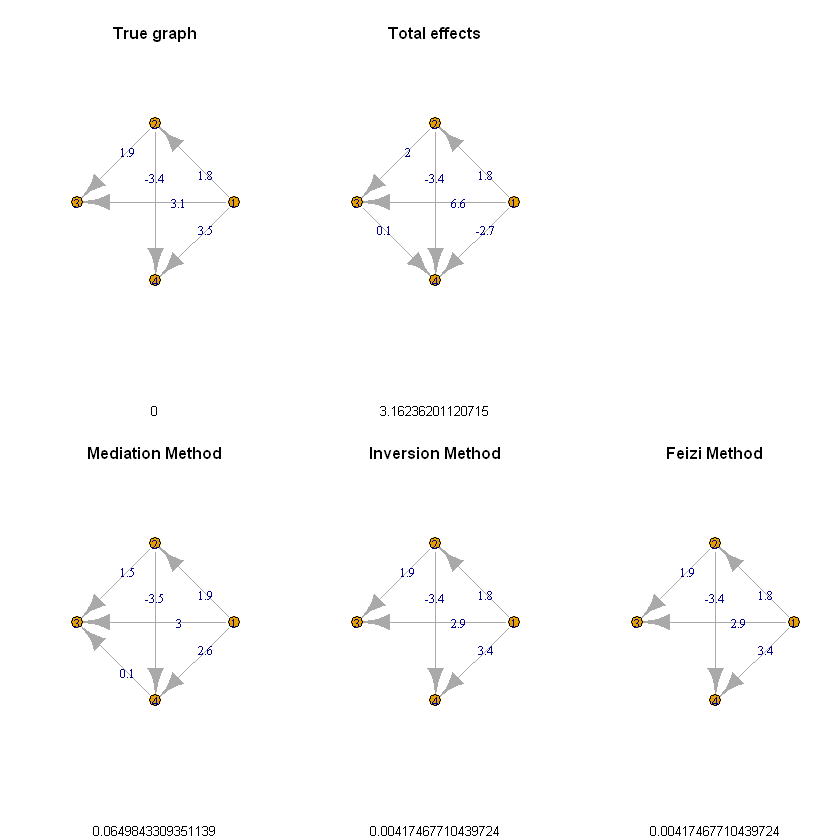

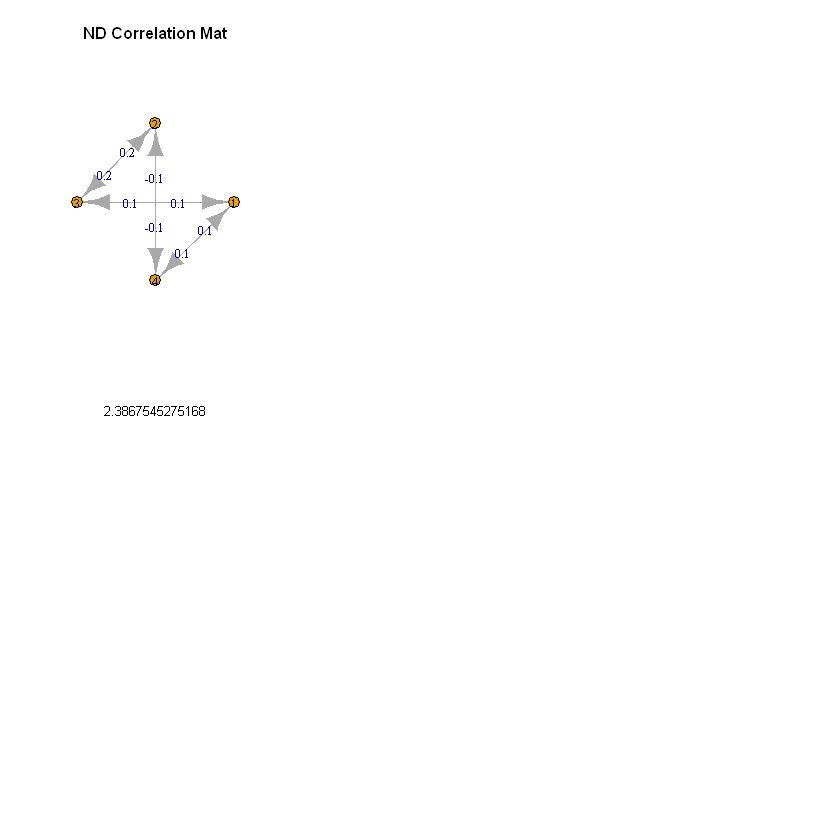

In [45]:
dat <- init_data(50000,4)
edg <- cbind(c(1,2),c(1,3),c(1,4),c(2,4),c(2,3))
#edg <- getRandomDag(5,0.5)
dat <- single_test(4, 50000, 0, 0, 0, prRes=TRUE, edgeset = edg, data = dat, broken=FALSE)